## Dataset


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

**Dataset saved into the folder data**

In [3]:
df = pd.read_csv('data/AER_credit_card_data.csv')
df.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,yes,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,yes,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,yes,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,yes,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,yes,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5


## Preparation


* Create the target variable by mapping `yes` to 1 and `no` to 0. 
* Split the dataset into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` funciton for that with `random_state=1`.

In [6]:
df.card = (df.card == 'yes').astype(int)

In [8]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df, test_size=0.2, random_state=1)

In [12]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.card.values
y_val = df_val.card.values
y_test = df_test.card.values

del df_train['card']
del df_val['card']
del df_test['card']

## Question 1


ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the `card` variable.
* Use the training dataset for that.

If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['expenditure']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `reports`
- `dependents`
- `active`
- `share`

In [55]:
from sklearn.metrics import roc_auc_score
rc_features = ['reports', 'dependents', 'active', 'share']
rc_list = [roc_auc_score(y_train, df_train[f]) if roc_auc_score(y_train, df_train[f]) > 0.5
                             else roc_auc_score(y_train, -df_train[f]) for f in rc_features]
print('Best roc_auc with ', rc_features[rc_list.index(max(rc_list))])


Best roc_auc with  share


**Answer : share**

## Training the model

From now on, use these columns only:

```
["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]
```

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

In [30]:
features = ["reports", "age", "income", "share", "expenditure",
            "dependents", "months", "majorcards", "active",
             "owner", "selfemp"]
dv = DictVectorizer(sparse=False)
train_dict = df_train[features].to_dict('records')
X_train = dv.fit_transform(train_dict)

In [42]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000).fit(X_train, y_train)

## Question 2


What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.615
- 0.515
- 0.715
- 0.995

In [43]:
val_dict = df_val[features].to_dict('records')
X_val = dv.transform(val_dict)

In [45]:
round(roc_auc_score(y_val, model.predict(X_val)), 3)

0.992

**Answer : 0.995**

## Question 3

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them


At which threshold precision and recall curves intersect?

* 0.1
* 0.3
* 0.6
* 0.8


In [61]:
from sklearn.metrics import precision_score, recall_score
import seaborn as sns

In [64]:
thresholds = np.arange(0.0, 1, 0.01)
precision_scores = []
recall_scores = []
for t in thresholds:
    prob = model.predict_proba(X_val)[:, 1]
    pred =  (prob >= t)
    precision_scores.append(precision_score(y_val, pred))
    recall_scores.append(recall_score(y_val, pred))


In [80]:
intersects = thresholds[(np.array(precision_scores) - np.array(recall_scores)) == 0]

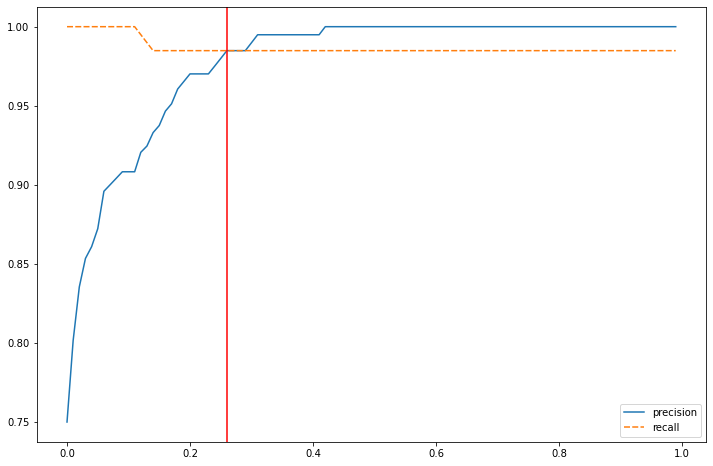

In [87]:
plt.figure(figsize=(12,8))
sns.lineplot(data=pd.DataFrame({'precision':precision_scores, 
                'recall':recall_scores}, index=thresholds))
plt.axvline(intersects[0], c='r');

In [88]:
intersects

array([0.26, 0.27, 0.28, 0.29])

**Answer : 0.3**

## Question 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

F1 = 2 * P * R / (P + R)

Where P is precision and R is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.1
- 0.4
- 0.6
- 0.7

## Question 5


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation


How large is standard devidation of the AUC scores across different folds?

- 0.003
- 0.014
- 0.09
- 0.24

## Question 6


Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: `[0.01, 0.1, 1, 10]`
* Initialize `KFold` with the same parameters as previously
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)


Which C leads to the best mean score?

- 0.01
- 0.1
- 1
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C
